In [1]:
import pandas as pd
import numpy as np
import os

import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker

import pandas.io.sql as psql
import psycopg2
conn = psycopg2.connect(dbname='churn', 
                        user='postgres',
                        password='postgres',
                        host='bi-assess.cvtbaved9qqg.us-west-2.rds.amazonaws.com',
                        port=5432)

In [2]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', None, 'display.max_columns', None)

## Part 1: Creating the churn attribute

Let's start by loading up the datasets into a database, since the intent is to demonstrate competency in SQL. I created a free micro instance on AWS RDS, with 100GB of storage.

In [3]:
dim_account = os.path.join('data', 'dim_account', '000')
dim_calendar = os.path.join('data', 'dim_calendar', '000')
dim_product = os.path.join('data', 'dim_product', '000')
dim_territory = os.path.join('data', 'dim_territory', '000')
fact_sales_revenue = os.path.join('data', 'fact_sales_revenue', '000')

In [4]:
# 0 means open
conn.closed

0

In [5]:
create_dim_account = """
    CREATE TABLE dim_account (
        payer_account_id TEXT, 
        payer_account_company_name TEXT,
        payer_account_registration_date TIMESTAMP WITHOUT TIME ZONE,
        payer_account_status_code TEXT,
        payer_account_role_name TEXT,
        payer_account_creation_date TIMESTAMP WITHOUT TIME ZONE,
        payer_account_last_update_date TIMESTAMP WITHOUT TIME ZONE,
        payer_account_registration_tax_country_code TEXT,
        is_payer_account_bill_in_90_days CHAR(1),
        is_payer_account_enterprise CHAR(1),
        is_payer_account_domain_free_domain CHAR(1),
        is_payer_account_on_enterprise_support CHAR(1),
        is_payer_account_on_business_support CHAR(1),
        is_payer_account_fraud CHAR(1),
        is_payer_account_suspended CHAR(1),
        is_payer_account_internal CHAR(1),
        is_payer_account_inp_terminated CHAR(1),
        is_payer_account_on_behalf_of CHAR(1),
        is_payer_account_tax_exempt CHAR(1),
        is_payer_account_reseller CHAR(1),
        payer_account_first_billing_reporting_date TIMESTAMP WITHOUT TIME ZONE,
        payer_account_first_payment_reporting_date TIMESTAMP WITHOUT TIME ZONE,
        payer_account_first_usage_date TIMESTAMP WITHOUT TIME ZONE
    );
"""

create_dim_calendar = """
    CREATE TABLE dim_calendar (
        calendar_sid INTEGER,
        calendar_date DATE,
        day_of_week_name TEXT,
        day_of_week_number INTEGER,
        day_of_week_code TEXT,
        day_of_quarter_number INTEGER,
        day_of_year_number INTEGER,
        calendar_period TEXT,
        week_id INTEGER,
        prior_week_id INTEGER,
        subsequent_week_id INTEGER,
        week_number INTEGER,
        week_code TEXT,
        month_id INTEGER,
        prior_month_id INTEGER,
        subsequent_month_id INTEGER,
        month_number INTEGER,
        month_code TEXT,
        month_num_of_days INTEGER,
        year_id INTEGER,
        prior_year_id INTEGER,
        subsequent_year_id INTEGER,
        year_number INTEGER,
        year_code TEXT,
        ytd_flag BOOLEAN,
        yoy_flag BOOLEAN,
        report_month_flag BOOLEAN,
        prospecting_day_flag BOOLEAN
    );
"""

create_dim_product = """
    CREATE TABLE dim_product (
        product_sid TEXT,
        product_line_name TEXT,
        product_name TEXT,
        sub_product_name TEXT,
        service_group_name TEXT,
        product_companyn_name TEXT
    );
"""

create_dim_territory = """
    CREATE TABLE dim_territory (
        territory_sid TEXT,
        region TEXT,
        sub_region TEXT,
        territory_code TEXT,
        segment TEXT
    );
"""

create_fact_sales_revenue = """
    CREATE TABLE fact_sales_revenue (
       territory_sid TEXT,
       payer_account_id TEXT,
       month_id INTEGER,
       product_sid TEXT,
       sales_revenue NUMERIC(38,6)
    );
"""

In [6]:
tables = [
#    'dim_account',
#    'dim_calendar',
#    'dim_product',
#    'dim_territory',
#    'fact_sales_revenue'
]

Some utility functions:

In [7]:
def select_print(query):
    try:
        cur = conn.cursor()
        cur.execute(query)
        data = cur.fetchall()
        print(data)
        conn.commit()
    except psycopg2.OperationalError as oe:
        print(oe)

In [8]:
select_print('SELECT now();')

[(datetime.datetime(2019, 4, 20, 4, 52, 52, 291015, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=0, name=None)),)]


In [ ]:
def create_table(tablename):
    try:
        cur = conn.cursor()
        func_name = 'create_' + tablename
        cur.execute(eval(func_name))
        conn.commit()
        print('Table ' + tablename + ' created.')
    except psycopg2.OperationalError as oe:
        print(oe)

In [ ]:
def copy_from_file(filepath, tablename):
    try:
        cur = conn.cursor()
        f = open(filepath, 'r')
        cur.copy_from(f, tablename, sep=',')
        conn.commit()
        f.close()
        print(filepath + ' copied into table ' + tablename + '.')
    except psycopg2.OperationalError as oe:
        print(oe)

In [ ]:
def execute_only(query):
    try:
        cur = conn.cursor()
        cur.execute(query)
        conn.commit()
        print('Done.')
    except psycopg2.OperationalError as oe:
        print(oe)

In [ ]:
%%time
for table in tables:
    create_table(table)
    copy_from_file(eval(table), table)

Wall time: 0 ns


First there are two things I want to be sure of: 

1. That each row in dim_account is distinct, i.e. we are storing state instead of transactions. E.g. when an account is suspended, and UPDATE is done, not an INSERT

2. That each row in fact_revenue_sales is the total monthly sales for that month_id, i.e. we are storing aggregates instead of transactions. If not, we need to aggregate the transactions to get the total monthly sales, since churn is a function of change in monthly sales.

In [ ]:
%%time
select_print('SELECT COUNT(*) from dim_account;')
select_print('SELECT COUNT(DISTINCT payer_account_id) FROM dim_account;')

[(21053889,)]
[(21053889,)]
Wall time: 51min 54s


Since both selects have the same value of 21053889, we've confirmed that dim_account stores the state of each account as identified by payer_account_id.

We have a lot of payer accounts, and the file dump of the fact_sales_revenue was roughly 1/4 the size of dim_account. How many accounts even have any transactions at all?

In [ ]:
%%time
select_print('SELECT COUNT(DISTINCT payer_account_id) FROM fact_sales_revenue;')

[(145061,)]
Wall time: 18min 32s


A mere 0.69% of payer accounts actually have transactions on file.. Let's set dim_account aside for now, and dive into fact_revenue_sales to answer the second question.

In [ ]:
select_num_transactions_per_month = """
    SELECT num_transactions, COUNT(payer_account_id) AS num_account_months
    FROM (SELECT payer_account_id, month_id, COUNT(sales_revenue) as num_transactions
        FROM fact_sales_revenue
        GROUP BY payer_account_id, month_id) subquery
    GROUP BY num_transactions
    ORDER BY num_transactions ASC;
"""

num_transactions_per_month_df = psql.read_sql(select_num_transactions_per_month, conn)

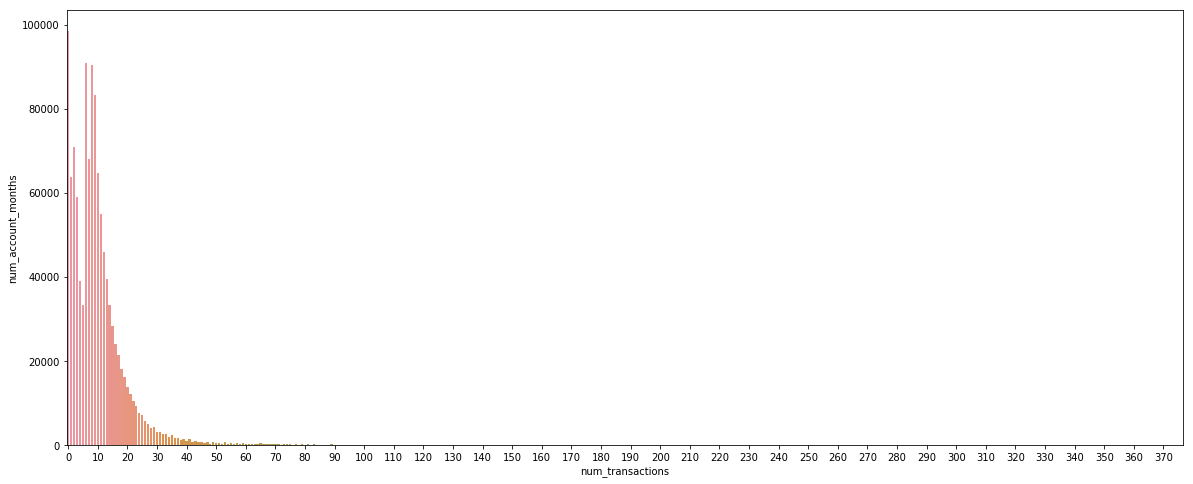

In [ ]:
plt.figure(figsize=(20,8))
X = num_transactions_per_month_df.num_transactions
Y = num_transactions_per_month_df.num_account_months

ax = sns.barplot(x=X, y=Y)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
plt.show()

Here we see a distribution of the number of transactions an account makes in a single month. It is of course heavily skewed toward a low number of transactions within a single month, but we see an interested uptick at 5 transactions per month, from whence it declines again. 

This suggests that there are at least two distributions of low-transaction payer-months, one which declines sharply from 1 transaction, and another which declines more gradually from 6 transactions per month.

Business-wise this means that there is some differentiable group of player-months where the number of transactions is consistantly high. This could mean either an opportunity to optimize by consolidating payments, or an opportunity to find out what is leading to more transactions in the latter group, and use it to increase the transaction count in the former group. 

* * *

However, we have not answered the second question we initially had: whether or not there is a single transaction per payer-month, i.e. whether the value in sales_revenue is for the entire month, or if we need to aggregate them per payer-month.

In [ ]:
%%time
select_multiple_transactions_per_payer_month = """
    SELECT * 
    FROM (SELECT payer_account_id, month_id, COUNT(sales_revenue) AS num_transactions
        FROM fact_sales_revenue
        GROUP BY payer_account_id, month_id) subquery
    WHERE num_transactions > 1
    LIMIT 100;
"""

multiple_transactions_per_payer_month_df = psql.read_sql(select_multiple_transactions_per_payer_month, conn)
print(multiple_transactions_per_payer_month_df.head())

And right away we can see easily enough that there are plenty of payers with more than one sales_revenue per month. Our hunch was correct, this is transactional data that needs to be aggregated.

Let's create another table to store the total monthly sales revenue of each payer.

In [ ]:
# %%time
# select_total_revenue_per_payer_month = """
#     SELECT payer_account_id, month_id, SUM(sales_revenue) as month_sales_revenue
#     INTO TABLE monthly_sales_revenue
#     FROM fact_sales_revenue
#     GROUP BY payer_account_id, month_id
# """

# execute_only(select_total_revenue_per_payer_month)

Also let's create a monthly calendar table for joining.

In [ ]:
# create_monthly_calendar = """
#     SELECT month_id, month_number, year_number
#     INTO monthly_calendar
#         FROM dim_calendar
#         GROUP BY month_id, month_number, year_number
# """

# execute_only(create_monthly_calendar)

Now we just need to add a column storing the churn attribute. 

An account is defined as having churned in a given month if its total transaction revenue in the previous year's month of December was above 1, but the same value in the month in concern is below 1. We can phrase this as a boolean conditional:

```
churn = previous_dec_revenue > 1 and month_sales_revenue < 1
```

We already created the month_sales_revenue attribute, so we just need to create the previous_dec_revenue attribute, then create the churn attribute based on these two attributes.

In [ ]:
# %%time
# select_into_churn = """
#     SELECT msr.payer_account_id, 
#         msr.month_id, mc.month_number, 
#         mc.year_number, 
#         msr.month_sales_revenue, 
#         mc2.year_number AS previous_year_number, 
#         mc2.month_id AS previous_dec_month_id, 
#         msr2.month_sales_revenue AS previous_dec_month_sales_revenue, 
#         (msr2.month_sales_revenue > 1 AND msr.month_sales_revenue < 1) AS churn
#     INTO churn
#         FROM monthly_sales_revenue msr
#         LEFT JOIN monthly_calendar mc ON msr.month_id = mc.month_id
#         LEFT JOIN monthly_calendar mc2 ON mc.year_number-1 = mc2.year_number AND mc2.month_number = 12
#         LEFT JOIN monthly_sales_revenue msr2 ON mc2.month_id = msr2.month_id AND msr2. payer_account_id = msr.payer_account_id
# """

# execute_only(select_into_churn)

Something I learnt about Postgres' handling of boolean values:

```
null AND false = false
null AND true = null
```

and the same goes if you swap the places of the conditions. 

This means that in our resulting table, the meanings of the churn variable are:
-  true : previous_dec_revenue > 1 __and__ month_sales_revenue < 1 
-  null : previous_dec_revenue = null __and__ month_sales_revenue < 1
-  false: previous_dec_revenue < 1 __or__ month_sales_revenue > 1, since null previous_dec_revenue means it was 0

In other words, we can consider null churn to be the same as false, since it means that previous_dec_revenue == 0.

With this, we have created the churn variable in the database. The next step is to find out the factors influencing churn, and since it's much more exploratory, I'll try to do most of it in Python using Pandas. There are 1160280 rows in the churn table, so it should be managable. Of course, I'll still have to make SQL queries to retrieve data to engineer features with. 

For more notes on the problems I faced along the way creating the churn variable, and how I approached them, please see the footnote at the bottom of this notebook. 

## Part 2: Identifying the causes of churn

Churn is an attribute identified by two factors: payer_account_id, and month_id. Hence, whatever is affecting churn must be a characteristic of one of these two entities: payer accounts, and the month in concern.

## Footnote
Along the way I ran into problems running queries that simply took too long, and I had to figure out what I was doing wrong... 

I starting with UPDATE to create calculated attributes:

In [ ]:
# Update monthly_sales_revenue with a column containing previous_dec_revenue

# create_prev_dec_revenue = """
#     ALTER TABLE monthly_sales_revenue
#     ADD COLUMN previous_dec_month_sales_revenue NUMERIC(38,6);
# """

# set_prev_dec_revenue = """
#     UPDATE monthly_sales_revenue 
#     SET previous_dec_month_sales_revenue = subquery.previous_dec_month_sales_revenue
#     FROM (SELECT msr.payer_account_id, msr.month_id, dc.month_number, dc.year_number, msr.month_sales_revenue, dc2.year_number AS previous_year_number, dc2.month_id AS previous_dec_month_id, msr2.month_sales_revenue AS previous_dec_month_sales_revenue
#         FROM monthly_sales_revenue msr
#         LEFT JOIN dim_calendar dc ON msr.month_id = dc.month_id
#         LEFT JOIN dim_calendar dc2 ON dc.year_number-1 = dc2.year_number AND dc2.month_number = 12
#         LEFT JOIN monthly_sales_revenue msr2 ON dc2.month_id = msr2.month_id) subquery
#     WHERE monthly_sales_revenue.payer_account_id = subquery.payer_account_id 
#     AND monthly_sales_revenue.month_id = subquery.month_id
# """

# execute_only(create_prev_dec_revenue)
# execute_only(set_prev_dec_revenue)

and when it took too long, I figured selecting into another table would be faster:

In [ ]:
# Creating a new table containing the previous_dec_revenue attribute, which should be faster than UPDATE

# %%time
# select_revenue_comparison = """
#     SELECT msr.payer_account_id, msr.month_id, dc.month_number, dc.year_number, msr.month_sales_revenue, dc2.year_number AS previous_year_number, dc2.month_id AS previous_dec_month_id, msr2.month_sales_revenue AS previous_dec_month_sales_revenue
#     INTO TABLE revenue_comparison
#     FROM monthly_sales_revenue msr
#         LEFT JOIN dim_calendar dc ON msr.month_id = dc.month_id
#         LEFT JOIN dim_calendar dc2 ON dc.year_number-1 = dc2.year_number AND dc2.month_number = 12
#         LEFT JOIN monthly_sales_revenue msr2 ON dc2.month_id = msr2.month_id
# """

# execute_only(select_revenue_comparison)

I tried using a function to store variables so that hopefully creating them procedurally would avoid consuming memory on the server:

In [ ]:
# Using a function to generate previous_dec_revenue procedurally

# function_previous_dec_revenue = """
#     CREATE FUNCTION previous_dec_monthly_sales_revenue(monthly_sales_revenue)
#     RETURNS NUMERIC(38,6) AS
#     $func$
#     SELECT previous_dec_month_sales_revenue 
#     FROM (SELECT msr.payer_account_id, msr.month_id, dc.month_number, dc.year_number, msr.month_sales_revenue, dc2.year_number AS previous_year_number, dc2.month_id AS previous_dec_month_id, msr2.month_sales_revenue AS previous_dec_month_sales_revenue
#         FROM monthly_sales_revenue msr
#         LEFT JOIN dim_calendar dc ON msr.month_id = dc.month_id
#         LEFT JOIN dim_calendar dc2 ON dc.year_number-1 = dc2.year_number AND dc2.month_number = 12
#         LEFT JOIN monthly_sales_revenue msr2 ON dc2.month_id = msr2.month_id) subquery
#     $func$ LANGUAGE SQL STABLE; 
# """

# execute_only(function_previous_dec_revenue)

None of the above approaches worked out in the sense of being able to be executed in a reasonable amount of time. In the case of the stored function, a simple select query with a very low limit faced the same problem.

So, I tried to break it down into smaller steps even if it winds up looking less elegant.

The first thing to do is make sure that I'm not crazy, and that my SQL works. Since instances where there was no transaction will come up as NULL, I'll omit those and limit the result to 500 rows:

In [ ]:
# %%time
# test_revenue_comparison = """
# SELECT msr.payer_account_id, msr.month_id, dc.month_number, dc.year_number, msr.month_sales_revenue, dc2.year_number AS previous_year_number, dc2.month_id AS previous_dec_month_id, msr2.month_sales_revenue AS previous_dec_month_sales_revenue
#     FROM monthly_sales_revenue msr
#     LEFT JOIN dim_calendar dc ON msr.month_id = dc.month_id
#     LEFT JOIN dim_calendar dc2 ON dc.year_number-1 = dc2.year_number AND dc2.month_number = 12
#     LEFT JOIN monthly_sales_revenue msr2 ON dc2.month_id = msr2.month_id
# WHERE msr2.month_sales_revenue IS NOT NULL
# LIMIT 500;
# """

# test_revenue_comparison_df = psql.read_sql(test_revenue_comparison, conn)
# print(test_revenue_comparison_df.head())

In [ ]:
# test_revenue_baseline = """
#     SELECT payer_account_id, month_id, month_sales_revenue 
#     FROM monthly_sales_revenue
#     WHERE payer_account_id LIKE 'PA000000000005593129'
#     AND month_id = 201512;
# """

# select_print(test_revenue_baseline)

No reason that wouldn't have been right, but it couldn't be any clearer after seeing the result of these two queries match up.

At this point I thought that I would have to index the tables, which I didn't want to do because I figured it wouldn't be worth it since I would only be querying them once to create the churn table which I would be using for my analysis.

At this point, I realized my mistake: The dim_calendar table is aggregated on a daily basis! Every join on month_id was duplicating the entire table ~30 times, and since I was joining twice that was 900 times. 

Using EXPLAIN also led me to realize that I also made an error in the LEFT JOIN of msr2; I have to join it on payer_account_id as well.

In [ ]:
# Used to clean up commits if an error is thrown.

curs = conn.cursor()
curs.execute("ROLLBACK")
conn.commit()